In [1]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from model import ExponentialKernelFiringRateModel, PolynomialActivation, GeneralizedFiringRateModel
from evaluate import explained_variance_ratio
from data import get_data, get_train_test_data, preprocess_data

pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format

In [17]:
def get_activation_plot(actv, start=-100, end=270):
    currents = torch.linspace(start, end, steps=300).reshape(-1, 1)
    with torch.no_grad():
        fs = actv(currents)
    return currents.reshape(-1), fs.reshape(-1)

def plot_activation(Is, fs, actv):
    plt.figure(figsize=(8, 4.5), dpi=1000)
    plt.scatter(Is, fs)
    xs1, ys1 = get_activation_plot(actv, end=int(actv.max_current)+300)
    plt.plot(xs1, ys1, linewidth=2)
    plt.xlabel("$I$ $(pA)$")
    plt.ylabel("$g(I)$ $(ms^{-1})$")

def plot_kernel(model, cell_id, bin_size, save=False, fname=None, xlim=10):
    fig = plt.figure(constrained_layout=True, figsize=(8, 4.5), dpi=1000)
    subfigs = fig.subfigures(1, 2)
    #fig.suptitle(f"cell_id={cell_id}, bin_size={bin_size}")
    xs = torch.linspace(0, xlim, 100)
    cs, ds = [], []
    with torch.no_grad():
        for x in xs:
            cs.append(model.kernel(x, var="a"))
            ds.append(model.kernel(x, var="b"))
    
    xs = xs * bin_size / 1000
    
    axs0 = subfigs[0].subplots(2)
    axs0[0].plot(xs,cs, linewidth=2)
    axs0[1].plot(xs,ds, linewidth=2)
    axs0[0].set_ylabel("$k_I(t)$")
    axs0[1].set_ylabel("$k_f(t)$")
    axs0[0].set_ylim([0, 3.4])
    axs0[1].set_ylim([-3.4, 0])
    axs0[1].set_xlabel("$t$ $(s)$")
    
    axs1 = subfigs[1].subplots(2)
    taus = -20/np.log(1-np.array([0.0198, 0.1131, 0.4727, 0.9716, 1.0000]))
    ks = [f"{i:.2f}" for i in taus]
    axs1[0].bar(ks, model.a.detach().reshape(-1))
    axs1[1].bar(ks, model.b.detach().reshape(-1))
    axs1[0].set_ylabel("$\\alpha_i$")
    axs1[1].set_ylabel("$\\beta_i$")
    axs1[1].set_xlabel("$\\tau_i$ (ms)")
    
    #fig.set_size_inches(8, 4.5, forward=True)

    if save:
        plt.savefig(config["fig_save_path"] + f"{cell_id}/bin_size_{bin_size}/{fname}.png")
        plt.close()

def plot_predictions(model, Is, fs, cell_id, bin_size, evr=None, xlim=None):
    pred_fs, vs = model.predict(Is)
    pred_fs = torch.cat([torch.zeros(1), pred_fs])
    vs = torch.cat([torch.zeros(1, 5), vs])
    Is = torch.cat([torch.zeros(1), Is])
    fs = torch.cat([torch.zeros(1), fs])
    ts = np.arange(Is.shape[0]) * bin_size / 1000
    

    fig, axs = plt.subplots(2, figsize=(6, 2.5), dpi=1000)
    
    axs[1].plot(ts, fs, label="Actual", linewidth=1)
    axs[1].plot(ts, pred_fs, label="Predicted", linewidth=1)
    #axs[2].plot(ts, vs, linewidth=1)
    axs[0].plot(ts, Is, linewidth=1)
    axs[1].legend()
    axs[1].set_ylabel("$f_t$ $(ms^{-1})$")
    #axs[2].set_ylabel("$\mathbf{h}_t$")
    axs[0].set_ylabel("$I_t$ $(pA)$")
    if xlim is not None:
        axs[0].set_xlim(xlim)
        axs[1].set_xlim(xlim)
        #axs[2].set_xlim(xlim)
    #axs[0].yaxis.set_ticklabels([])
    #axs[1].yaxis.set_ticklabels([])
    axs[0].set_ylim([-10, 230])
    axs[1].set_ylim([-0.003, 0.06])
    axs[0].xaxis.set_ticklabels([])
    #axs[1].xaxis.set_ticklabels([])
    #axs[2].xaxis.set_ticklabels([])
    axs[1].set_xlabel("$t$ $(s)$")
    fig.tight_layout()

In [11]:
def get_params(bin_size, activation_bin_size, n):
    params = {}
    save_path = f"model/params/{bin_size}_{activation_bin_size}_{n}/"
    for fname in os.listdir(save_path):
        if fname.endswith(".pickle"):
            cell_id = int(fname.split(".")[0])
            with open(f"{save_path}{fname}", "rb") as f:
                params[cell_id] = pickle.load(f)
    return params

def get_all_params():
    bin_sizes = [10, 20, 50, 100]
    activation_bin_sizes = [20, 100]
    degrees = [1, 3]
    n_kernels = [5, 7]
    
    params = {}
    
    for bin_size in bin_sizes:
        for activation_bin_size, degree in zip(activation_bin_sizes, degrees):
            if activation_bin_size >= bin_size:
                for n in n_kernels:
                    params[(bin_size, activation_bin_size, n)] = get_params(bin_size, activation_bin_size, n)
                                
    return params

def get_best_params(params, bin_size):
    best_params = {}
    
    cell_ids = set()
    for config in params:
        cell_ids = cell_ids.union(set(params[config].keys()))
    
    for cell_id in cell_ids:
        best_config = None
        best_evr = -1e10
        
        for config in params:
            if config[0] == bin_size and cell_id in params[config] and params[config][cell_id]["evr2"] > best_evr:
                best_evr = params[config][cell_id]["evr1"]
                best_config = config
        
        # doesn't make sense
        if best_config is not None:
            best_params[cell_id] = params[best_config][cell_id]
        
    return best_params


def visualize_data(params):
    data = {"cell_id": [], "evr1": [], "evr2": [], "loss": [], "epochs": []}

    for cell_id in params:
        data["cell_id"].append(cell_id)
        data["evr1"].append(params[cell_id]["evr1"])
        data["evr2"].append(params[cell_id]["evr2"])
        data["loss"].append(params[cell_id]["losses"][-1])
        data["epochs"].append(len(params[cell_id]["losses"]))

    df = pd.DataFrame(data)
    df = df.set_index("cell_id")
    df = df.sort_values("evr2")

    print(f"Total number of cells: {len(df)}")
    print(f"Number/proportion of cells with evr<=0: {len(df[df['evr2'] <= 0])}/{len(df[df['evr2'] <= 0]) / len(df)}")
    print(f"Number/proportion of cells with epochs<50: {len(df[df['epochs'] < 50])}/{len(df[df['epochs'] < 50]) / len(df)}")

    df_corrected = df[df["evr1"] > 0.01]
    print(f"Median evr: {np.median(df_corrected.dropna()['evr2'].values)}")

    evrs1 = df_corrected.iloc[:, 0]
    evrs2 = df_corrected.iloc[:, 1]
    losses = df_corrected.iloc[:, 2]

    plt.figure()
    plt.hist(evrs2, bins="auto")
    plt.xlabel("evr2")
    plt.ylabel("counts")
    plt.title("evr2 histogram (failed optimizations removed)")

    plt.figure()
    plt.hist(losses, bins="auto")
    plt.xlabel("loss")
    plt.ylabel("counts")
    plt.title("loss histogram (failed optimizations removed)")

    plt.figure()
    plt.scatter(evrs2, losses, alpha=0.5)
    plt.xlabel("evr2")
    plt.ylabel("loss")
    plt.title("evr2 vs loss scatter plot (failed optimizations removed)")

    plt.figure()
    plt.scatter(evrs1, evrs2, alpha=0.5)
    plt.xlabel("evr1")
    plt.ylabel("evr2")
    plt.title("evr1 vs evr2 scatter plot (failed optimizations removed)")
    
    return df

def summarize(params):
    data = {"cell_id": [], "evr1": [], "evr2": [], "loss": [], "epochs": []}

    for cell_id in params:
        data["cell_id"].append(cell_id)
        data["evr1"].append(params[cell_id]["evr1"])
        data["evr2"].append(params[cell_id]["evr2"])
        data["loss"].append(params[cell_id]["losses"][-1])
        data["epochs"].append(len(params[cell_id]["losses"]))

    df = pd.DataFrame(data)
    df = df.set_index("cell_id")
    df = df.sort_values("evr2")
    df_corrected = df[df["evr1"] > 0.01].dropna()
    
    return {
        "n_cells": len(df),
        "p_zero_evr": len(df[df['evr2'] < 0.01]) / len(df),
        "p_early_stop": len(df[df['epochs'] < 50]) / len(df),
        "corrected_median_evr": np.median(df_corrected['evr2'].values)
    }

def summarize_all_models(all_params):
    summ = {}
    for config in all_params:
        summ[f"bin_size={config[0]}, activation_bin_size={config[1]}, n_kernels={config[2]}"] = summarize(all_params[config])
    for bin_size in [10, 20, 50, 100]:
        best_params = get_best_params(all_params, bin_size)
        summ[f"Best for {bin_size=}:"] = summarize(best_params)
    print(nice_dict(summ))
    
def nice_dict(d, indent=0):
    s = []
    for i in d:
        if type(d[i]) == dict:
            s.append(f"{i}\n{nice_dict(d[i], indent=indent+1)}")
        elif type(d[i]) == float:
            s.append(f"{i}: {d[i]:.4f}")
        else:
            s.append(f"{i}: {d[i]}")
    return "\n".join(["| "*indent + x for x in s])

In [8]:
-20/np.log(1-np.array([0.0198, 0.1131, 0.4727, 0.9716, 1.0000]))

/var/folders/1d/cmypn_251jlfyvc132scjqd40000gp/T/ipykernel_76352/257953590.py:1: RuntimeWarning: divide by zero encountered in log
  -20/np.log(1-np.array([0.0198, 0.1131, 0.4727, 0.9716, 1.0000]))


array([1000.06767925,  166.6346692 ,   31.25070156,    5.61582248,
          0.        ])

In [4]:
params = get_all_params()

In [7]:
ps = []
for bin_size in [10, 20, 50, 100]:
    ps.append(get_best_params(params, bin_size))

In [8]:
evrs = {}
bin_sizes = [10, 20, 50, 100]
for i, p in enumerate(ps):
    evr = []
    for cell_id in p:
        evr.append(p[cell_id]["evr2"])
    evrs[f"$\\Delta t={bin_sizes[i]}$"] = evr

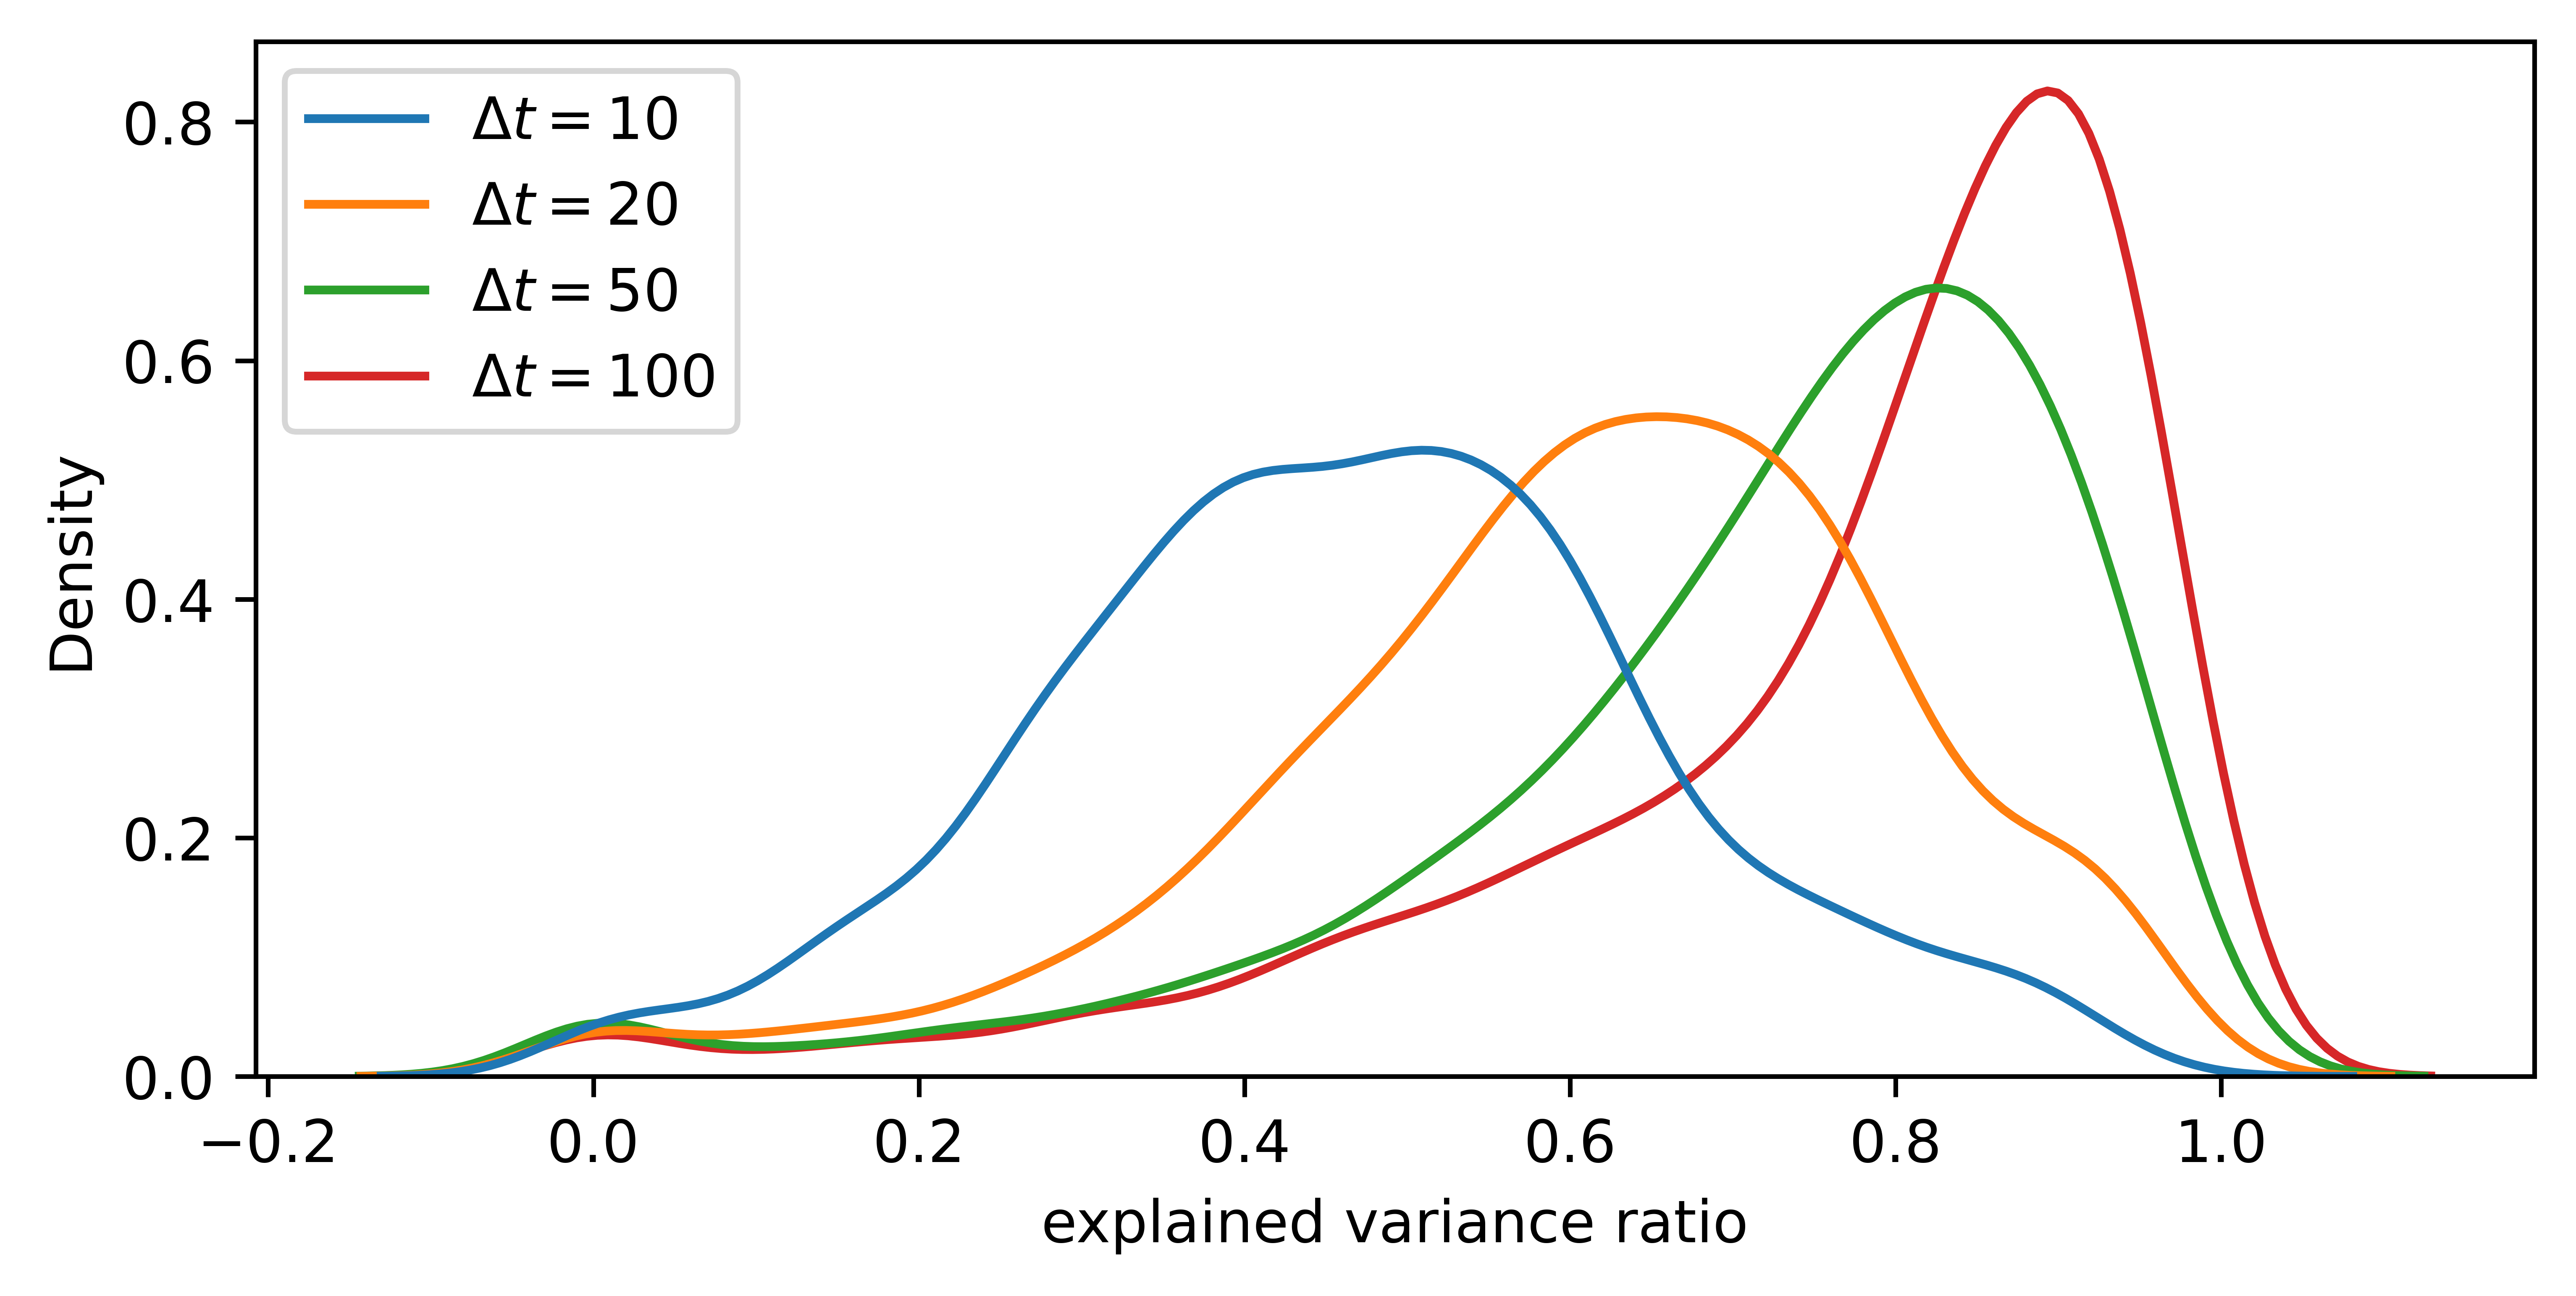

In [9]:
plt.figure(figsize=(7, 3.2), dpi=1000)
sns.kdeplot(evrs)
plt.xlabel("explained variance ratio");

In [12]:
bin_size = 20
activation_bin_size = 100
n_kernels = 5

params = get_params(bin_size, activation_bin_size, n_kernels)
print(len(params))

1827


Total number of cells: 1827
Number/proportion of cells with evr<=0: 14/0.007662835249042145
Number/proportion of cells with epochs<50: 15/0.008210180623973728
Median evr: 0.5732181087294248


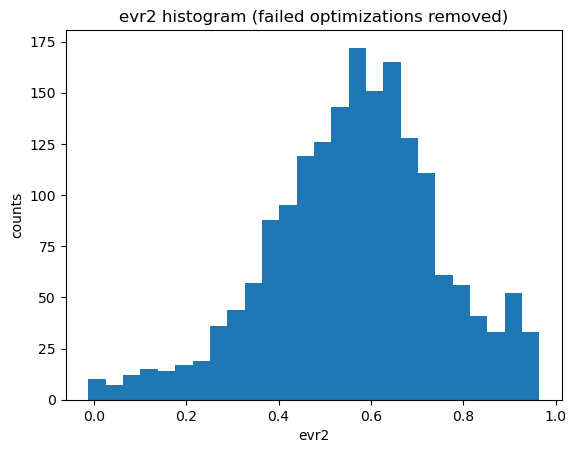

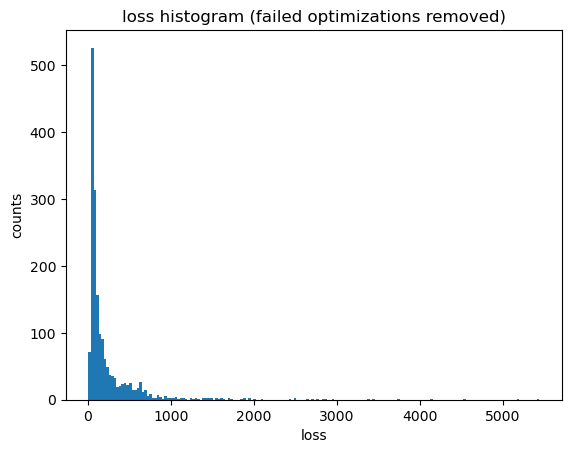

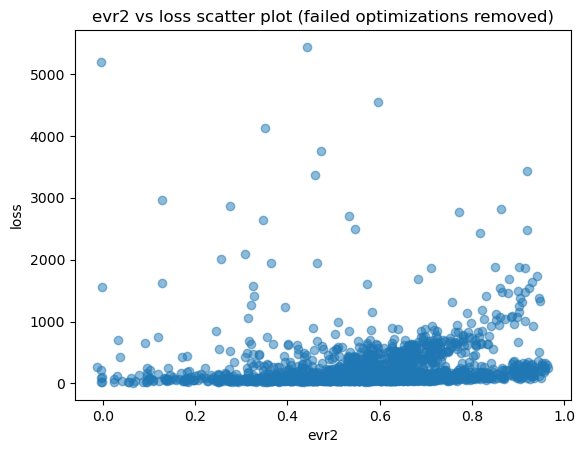

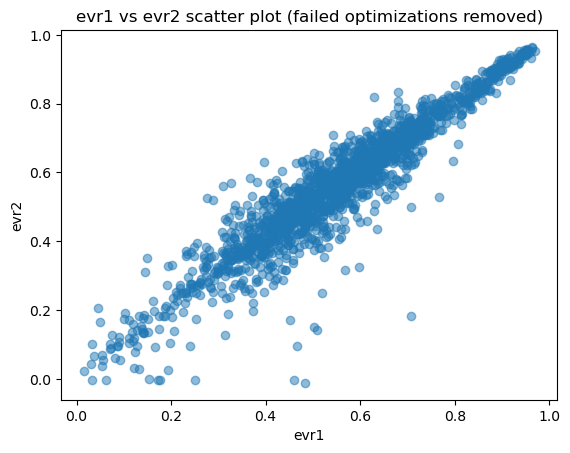

In [9]:
df = visualize_data(params)

In [10]:
df

,evr1,evr2,loss,epochs
cell_id,,,,
476764144,0.483,-0.012,262.861,500
318362027,0.033,-0.004,29.103,500
471088062,0.251,-0.003,"5,192.505",500
476751360,0.177,-0.003,81.526,500
487638658,0.172,-0.003,210.364,400
484818613,0.063,-0.002,"1,561.794",500
481096407,0.459,-0.002,111.080,500
561936316,0.153,-0.001,27.754,500
576046210,0.000,-0.000,"3,879.163",3


In [18]:
def visualize(cell_id, params, bin_size=20):
    model = ExponentialKernelFiringRateModel.from_params(params[cell_id]["params"])
    data = get_data(cell_id, aligned=True)
    Is_tr, fs_tr, _, _, Is_te, fs_te, stims = get_train_test_data(data, bin_size)
    Is_actv, fs_actv = preprocess_data(data, bin_size=params[cell_id]["params"]["g"]["bin_size"])
    
    def _plot_train_data():
        for Is, fs, s in zip(Is_tr, fs_tr, stims):
            if torch.sum(fs) > 0.2:
                for i in range(Is.shape[0]):
                    plot_predictions(
                        model, 
                        Is[i, :], 
                        fs[i, :], 
                        cell_id, 
                        bin_size, 
                        evr = None
                    )
                
    def _plot_noise2():
        r = explained_variance_ratio(model, Is_te[0], fs_te[0], bin_size)
        print(Is_te[0][0, :].shape)
        plot_predictions(
            model, 
            Is_te[0][0, :], 
            fs_te[0][0, :], 
            cell_id, 
            bin_size, 
            evr = r,
            xlim = [15, 20]
        )
    
    def _plot_kernel():
        plot_kernel(
            model,
            cell_id,
            bin_size,
            save = False,
            xlim = 25
        )
    
    def _plot_activation():
        plot_activation(
            Is_actv,
            fs_actv,
            model.g
        )
    
    def _plot_losses():
        losses = params[cell_id]["losses"]
        plt.figure()
        plt.plot(list(range(len(losses))), losses)
        plt.xlabel("epochs")
        plt.ylabel("loss")
        
    #_plot_train_data()
    #_plot_noise2()
    _plot_kernel()
    #_plot_activation()
    #_plot_losses()

/var/folders/1d/cmypn_251jlfyvc132scjqd40000gp/T/ipykernel_76352/2658066254.py:38: RuntimeWarning: divide by zero encountered in log
  taus = -20/np.log(1-np.array([0.0198, 0.1131, 0.4727, 0.9716, 1.0000]))


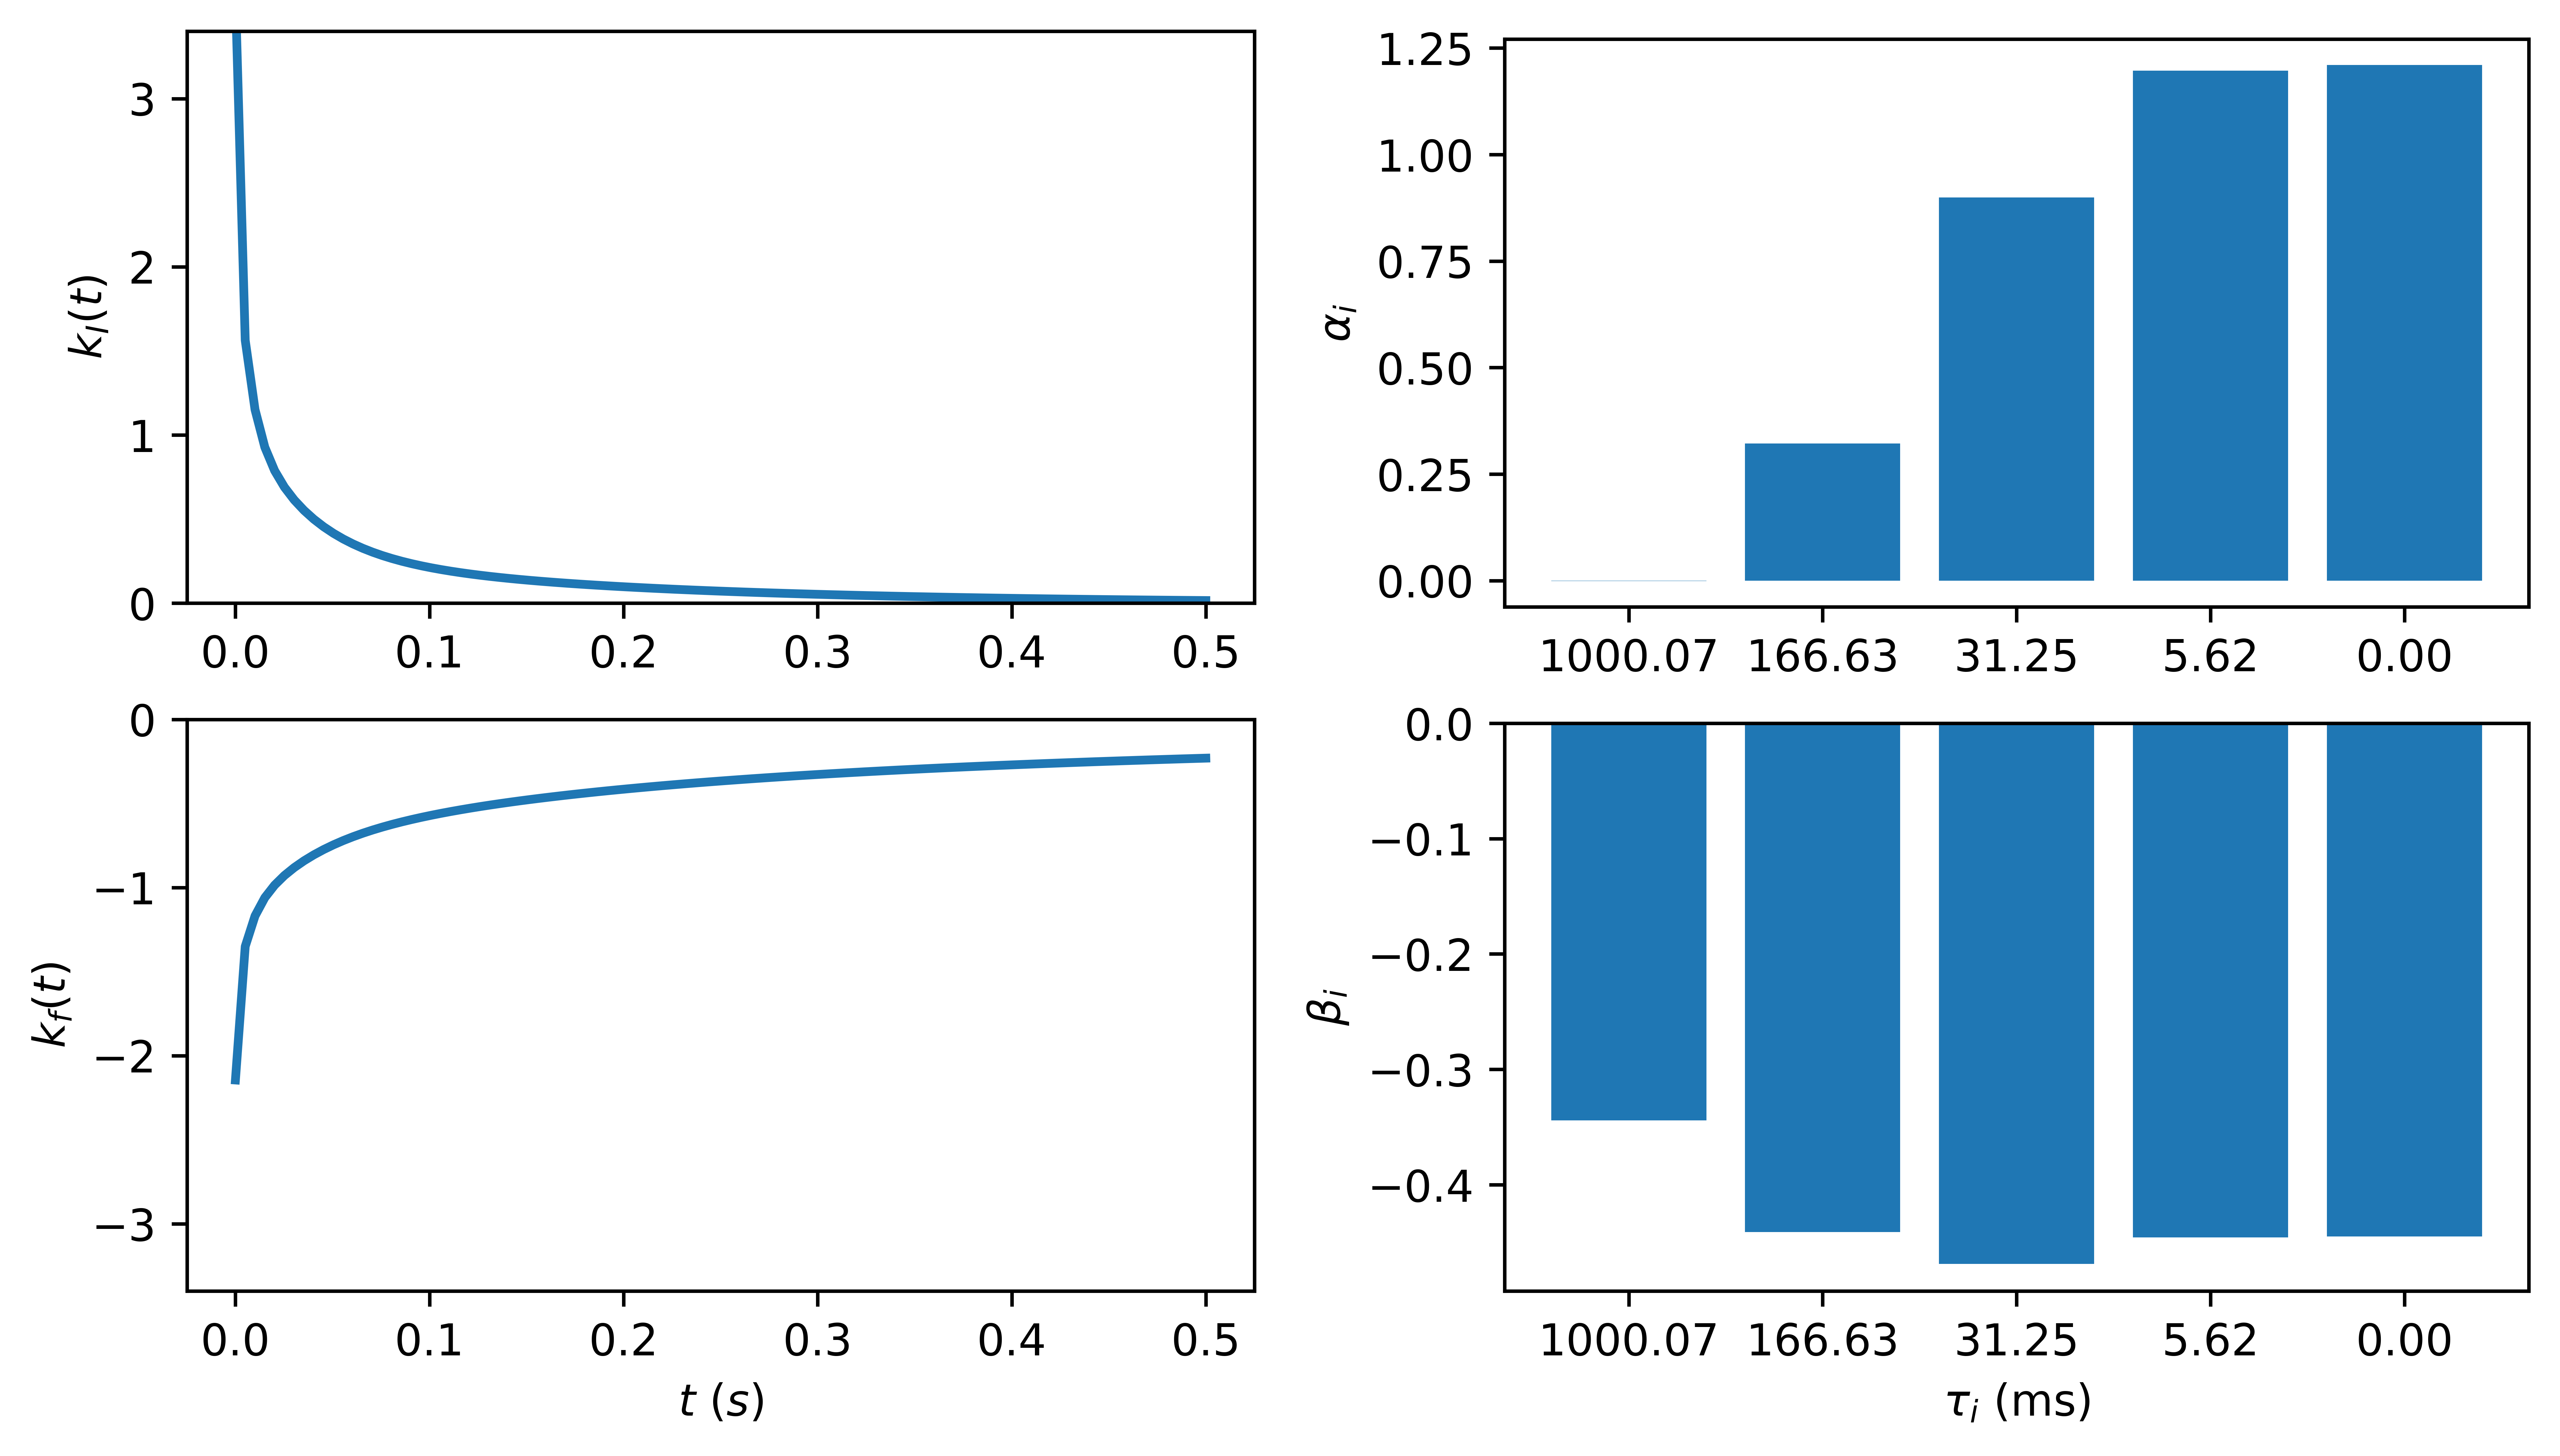

In [19]:
plt.rcParams.update({'figure.max_open_warning': 0})
visualize(557194325, params)